# process spectra for AuxTel with new spectractor (September 2021)

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : October 14th 2021
- last update : November 2nd 2021
- version v4 : Work with new exposure format quickLookExp_v2


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

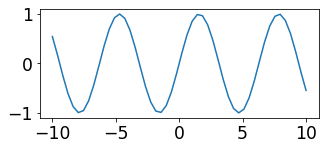

In [2]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [3]:
from iminuit import Minuit
import iminuit

In [4]:
iminuit.__version__

'2.7.0'

In [5]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [6]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [7]:
from distutils.dir_util import copy_tree
import shutil

# Configuration

In [8]:
version="v4.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True

FLAG_REMOVE_WCS=False

# Path

In [9]:
# path index for each month
DATE="2021-07-07"
DATE2="2021_07_07"

In [10]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [11]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/holo/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

# Utility Functions

In [12]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [13]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [14]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [15]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_' + version+'.csv'

In [16]:
df=pd.read_csv(filename_logbook,index_col=0)

In [17]:
pd.set_option('display.max_rows', None)

In [18]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,2000.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,2000.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [19]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [20]:
#idx=76
#idx=96
#idx=76 # start of narrow scan

# Wide scan

#idx= 19  # outside
#idx=20 # outsie
#idx=21 # outside
#idx=22 # outside
#idx=23 # outside
#idx=24 # outside
#idx=25 # outside

#idx=26

idx=35    # OK mais tronqué
#idx=36   # OK mais tronqué
#idx=37   # CRASH
#idx=38    # GOOD
#idx=39        # GOOD
#idx=40       # GOOD
#idx=41      # CRASH
#idx=42     # BAD, BAD STAR
#idx=43     # OUT
#idx=44     # OK
#idx=45    # OK
#idx= 46  # OK
#idx= 47   # crash
#idx=48   # OK
#idx=49   # NON
#idx=50   # OK
#idx=51   # OK
#idx=52   # OK
#idx=53   # OK
#idx=54   # OK
#idx=55   # OK
#idx=56   # OK
#idx=57   # OK
#idx=58   # NON

#idx=75

#--------

# narrow scan


#idx=111 # failed too close from border
#idx=112 # failed too close from border
#idx=113 # failed too close from border
#idx=114 # failed too close from border
#idx=115 # failed too close from border
#idx=116 # failed too close from border
#idx=117 # failed too close from border
#idx=118 # failed too close from border
#idx=119 # failed too close from border
#idx=120 # failed too close from border
#idx=121 # failed too close from border
#idx=122 # failed too close from border
#idx=123 # failed too close from border

In [21]:
print(df.iloc[idx]['file'])

holo4_003_empty_HD160617_20210707_000269_quickLookExp.fits


In [22]:
print(df.iloc[idx])

index                                                         35
date                                     2021-07-08T03:43:13.804
path           /Users/dagoret/DATA/AuxTelData2021/holo/quickL...
file           holo4_003_empty_HD160617_20210707_000269_quick...
num                                                          269
object                                                  HD160617
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.018155
exposure                                                    20.0
focus                                                  -1.588317
seeing                                                       NaN
pressure                                                   742.5
temperature                                                 12.2
humidity                                                     5.0
windspd                  

In [23]:
myhome=os.getenv("HOME")

In [24]:
dir_images=path_images

In [25]:
dir_images

'/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07'

In [26]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_HD160617_20210707_000269_quickLookExp.fits'

In [27]:
file_target(filename_image)

'HD160617'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [28]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [29]:
FLAG_ORDER0_LOCATION=False

In [30]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

Order 0 location from logbook : (2200.0,2700.0)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [31]:
filename_image.split(".")[0]

'holo4_003_empty_HD160617_20210707_000269_quickLookExp'

In [32]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [33]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_holo_scan"
output_figures="figures_process_holo_scan"

# Final output directory


guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [34]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp'

### manage output dir

In [35]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [36]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
    else:
        cleandir(output_directory)
 
    # manage subdirs spectrum/ and plots/
    if not os.path.isdir(output_figures):
        os.mkdir(output_figures)
    else:
        cleandir(output_figures)
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        #cleandir(finalpath_output_spectractor)
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

# Configuration of the Spectractor running mode

In [37]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

## Load the image in the new image file with Spectractor

In [38]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)

## Show relevant parameters

In [39]:
parameters.OBS_NAME

'AUXTEL'

In [40]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [41]:
parameters.DISTANCE2CCD

182.0

In [42]:
parameters.LAMBDA_MIN 

300

In [43]:
parameters.LAMBDA_MAX 

1100

In [44]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [45]:
image.filter_label

''

In [46]:
image.header["FILTER"]

'empty_1'

In [47]:
#image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

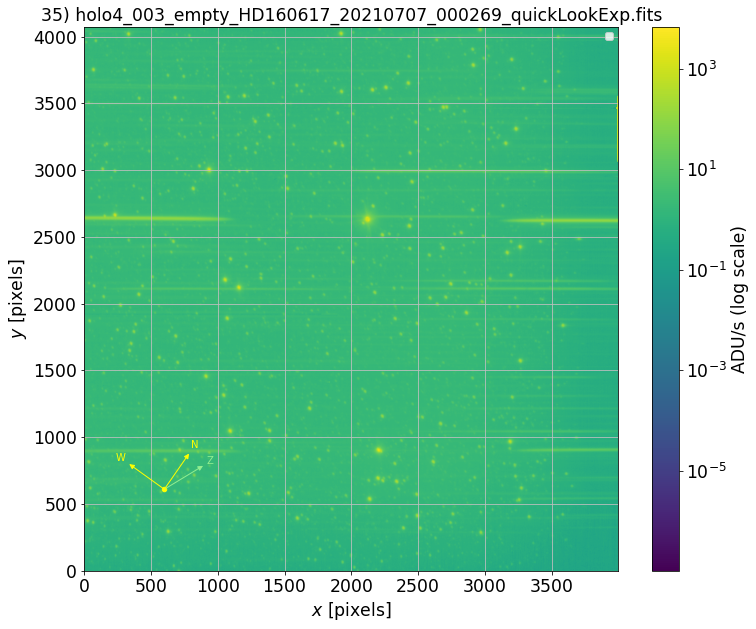

In [48]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [49]:
filename_image

'holo4_003_empty_HD160617_20210707_000269_quickLookExp.fits'

In [50]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

Set Order 0 location from logbook : (2200.0,2700.0)


## Let Spectractor find the location of the 0th order

2021-11-03 22:32:25  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                  c0_1        
    ----------------- --------------------- ---------------------
    5.252955691632573 -0.012438561718791744 -0.010283550456742343
2021-11-03 22:32:26  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 19 iterations because the relative change of cost is below ftol=1.25e-05.


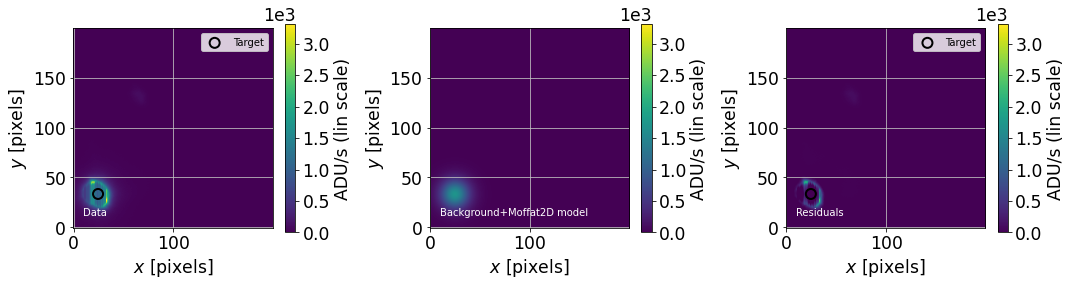

2021-11-03 22:32:26  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=8.140670791273201e-05.


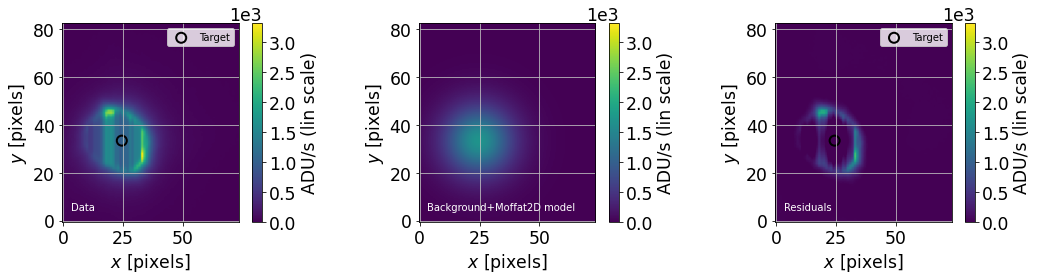

In [51]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [52]:
print(x1,y1)

2124.4385968984157 2633.4498286671464


## Check the location of 0th order and Analysis of the quality of its focus

In [53]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [54]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [55]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [56]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [57]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [58]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [59]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [60]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [61]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [62]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [63]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [64]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [65]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

<ipython-input-66-9da0d4ef5b3f>:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle(title,Y=1.01)


Text(0.5, 1.01, '35) holo4_003_empty_HD160617_20210707_000269_quickLookExp.fits')

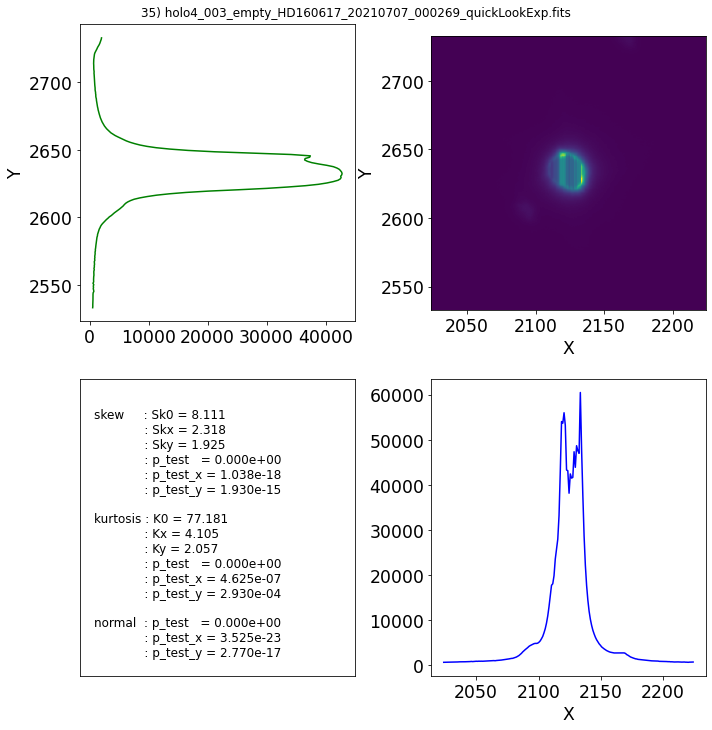

In [66]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title,Y=1.01)

In [67]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [68]:
#parameters.debug=True
#parameters.verbose=True
#parameters.display=True
#parameters.LIVE_FIT=False

In [69]:
parameters.debug=False
parameters.verbose=False
parameters.display=True
parameters.LIVE_FIT=False

In [70]:
filename

'/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp.fits'

2021-11-03 22:32:28  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-11-03 22:32:28  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp.fits...
2021-11-03 22:32:28  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: False	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: False	 <class 'bool'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> par

2021-11-03 22:32:28  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-11-03 22:32:28  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-11-03 22:32:28  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-11-03 22:32:33  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 160617 17 42 49.3235 -40 19 15.505 ... 0.0003350                1
2021-11-03 22:32:33  Star       load_spectra         INFO   
	Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd160617_stis_001.fits
2021-11-03 22:32:33  Star       load_

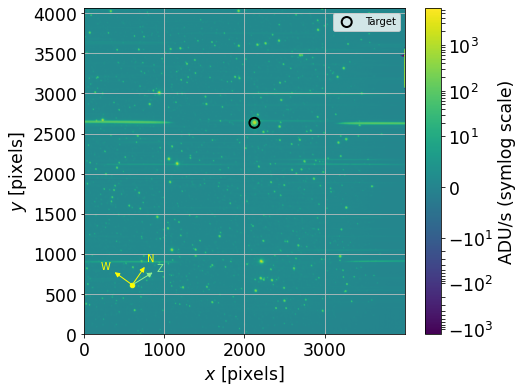

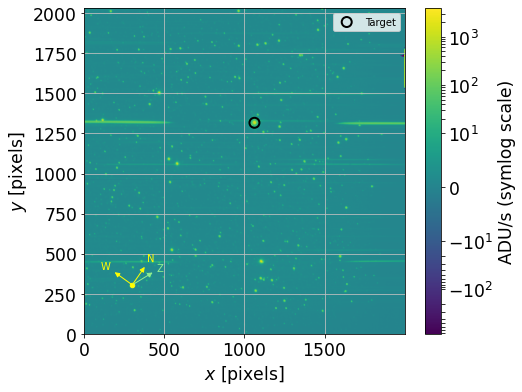

2021-11-03 22:32:39  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[1062.21929845 1316.72491433]...
2021-11-03 22:32:39  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                 c0_1        
    ----------------- --------------------- --------------------
    3.891520438464627 0.0003517263966494013 0.004309799371220295
2021-11-03 22:32:39  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 15 iterations because the relative change of cost is below ftol=5e-05.


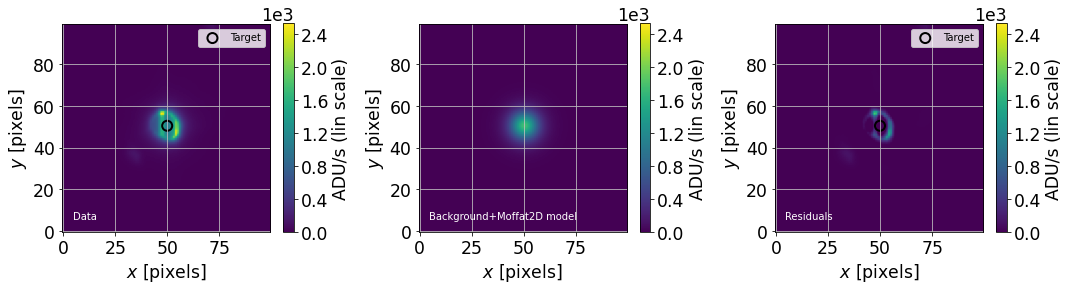

2021-11-03 22:32:40  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=0.0002.


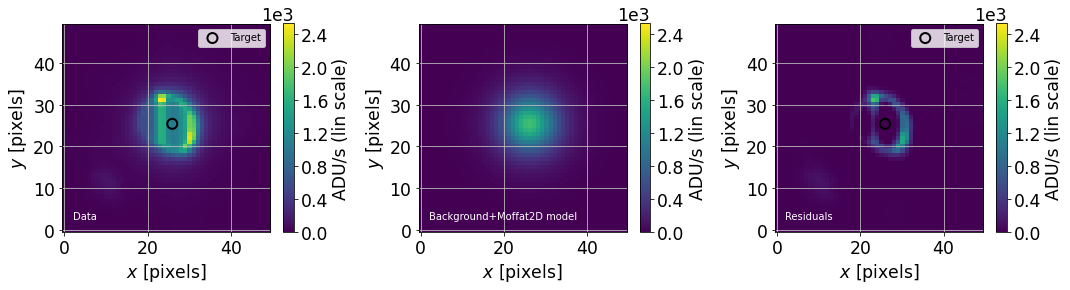

2021-11-03 22:32:41  Image      find_target          INFO   
	X,Y target position in pixels: 1061.942,1316.441
2021-11-03 22:32:41  Image      turn_image           INFO   
	Rotate the image with angle theta=0.00 degree


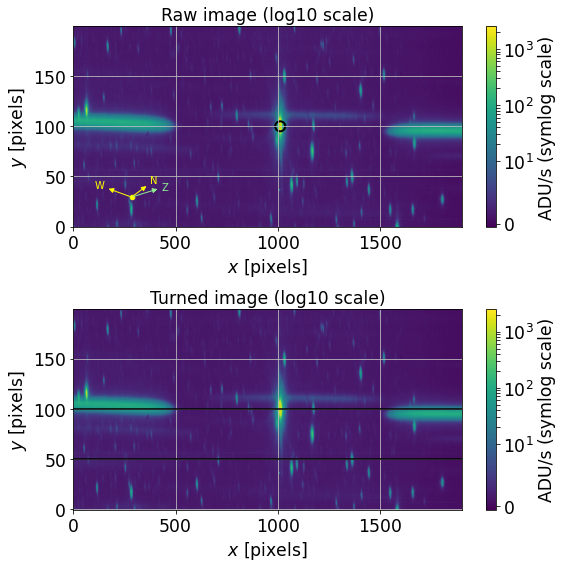

2021-11-03 22:32:45  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-11-03 22:32:45  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                c0_1        
    ------------------ ------------------- --------------------
    16.317030014896584 0.07827606319070984 0.034289806432648895
2021-11-03 22:32:45  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 7 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


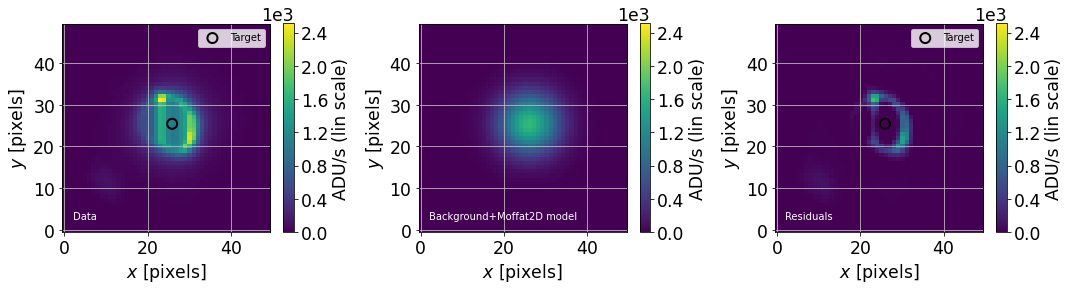

2021-11-03 22:32:46  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


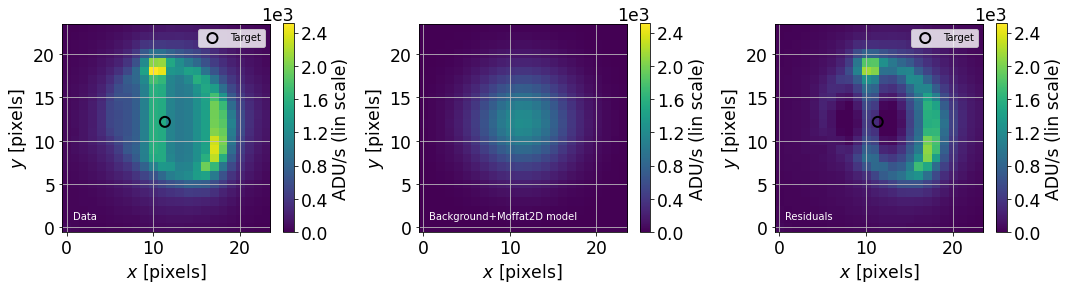

2021-11-03 22:32:47  Image      find_target          INFO   
	X,Y target position in pixels: 1060.346,1316.177
2021-11-03 22:32:47  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-11-03 22:32:47  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 70 to 90 pixels
2021-11-03 22:32:47  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [1487:1999,1226:1406] (size (512, 180))


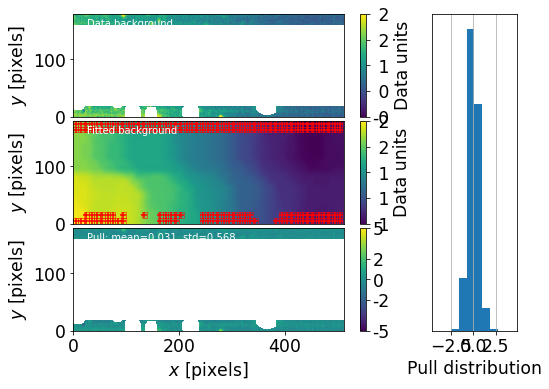

2021-11-03 22:32:49  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...


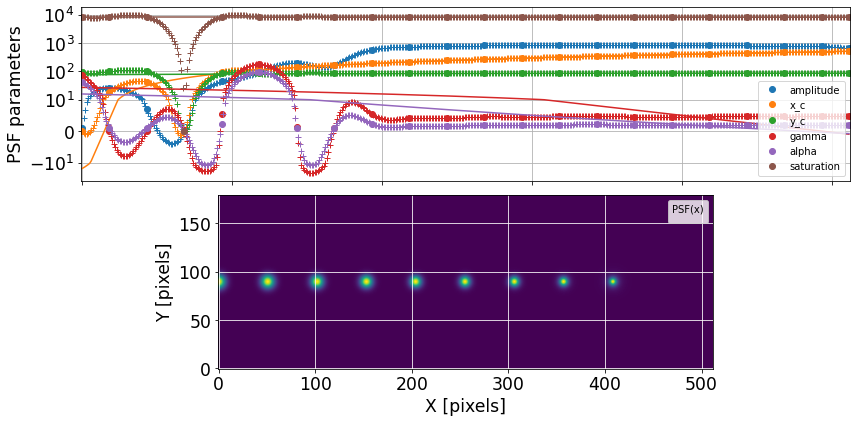

2021-11-03 22:32:51  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.5212e+05 initial chisq_red=7.4275
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.43847957  0.89201613 -0.66403872 -3.20449407  6.68467868 -5.15417672
 -2.12795323  4.33294331 -3.24442486]
	New parameters: [-4.83022532  0.28103558 -0.48209706  5.63460477 -2.09615066  1.65588147
  2.18190572 -0.51004537  0.51924967]
	Final cost=1.1041e+05 final chisq_red=5.3909 computed in 0.25s
2021-11-03 22:32:51  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.1041e+05 initial chisq_red=5.3909
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.00833762 -0.01871025  0.01203838 -1.47442874  3.4094797  -2.11146174
 -0.52127894  1.35134368 -0.82020717]
	New parameters: [-4.8218877   0.26232533 -0.47005868  4.16017604  1.31332903 -0.45558027
  1.66062678  0.84129831 -0.3009575 ]
	Final cost=1.0409e+05 final chisq_red=5.0827 computed i

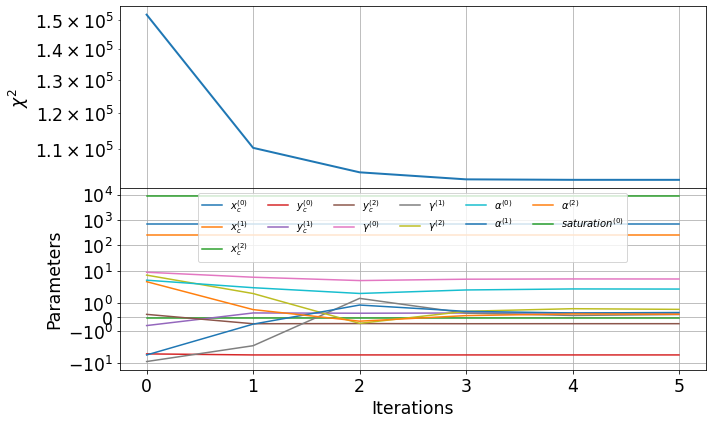

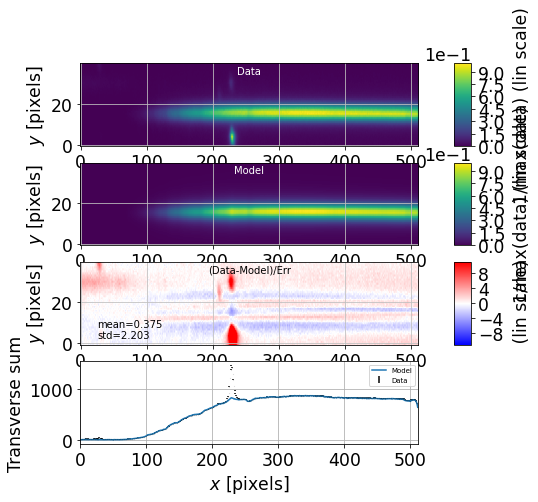

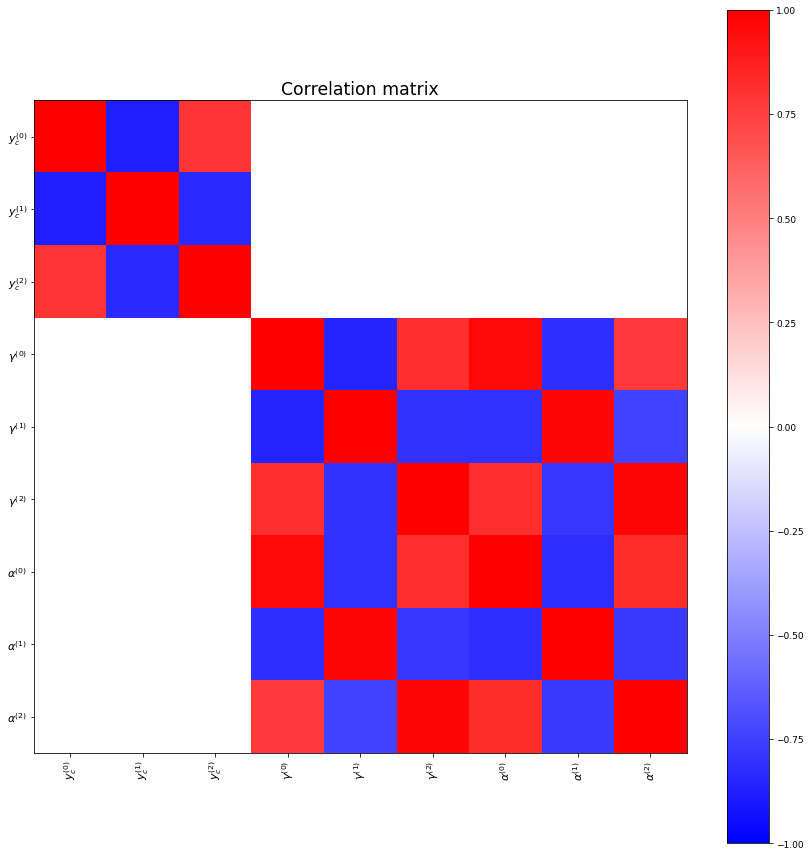

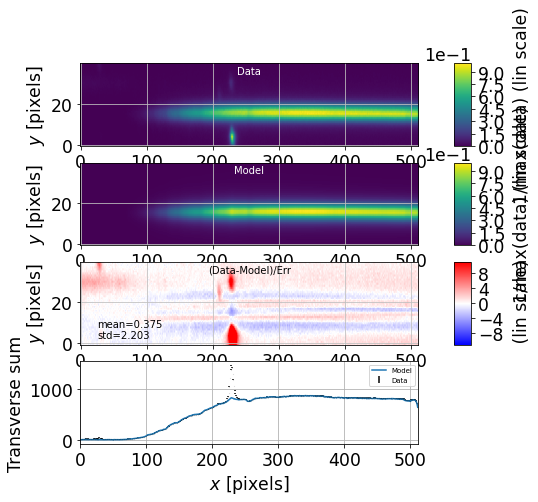

2021-11-03 22:32:58  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
     amplitude        x_c  ...          Dy         Dy_disp_axis
-------------------- ----- ... ------------------- ------------
 -3.5740506122428504   0.0 ...  -5.582065713866584          0.0
  -0.759525702806521   1.0 ...  -5.575377076782345          0.0
 -2.3048106354739293   2.0 ... -5.5687104294894425          0.0
 -0.9200674096773239   3.0 ...  -5.562065771987889          0.0
 0.26805058486676464   4.0 ...  -5.555443104277657          0.0
 -0.9101518372104914   5.0 ...   -5.54884242635876          0.0
 -0.3851781046270923   6.0 ...  -5.542263738231213          0.0
  3.5522650781501963   7.0 ... -5.5357070398950015          0.0
-0.10988966939757015   8.0 ...  -5.529172331350111          0.0
  1.4402518556913022   9.0 ...   -5.52265961259657          0.0
                 ...   ... ...                 ...          ...
   771.0718557408027 501.0 ...  -4.985

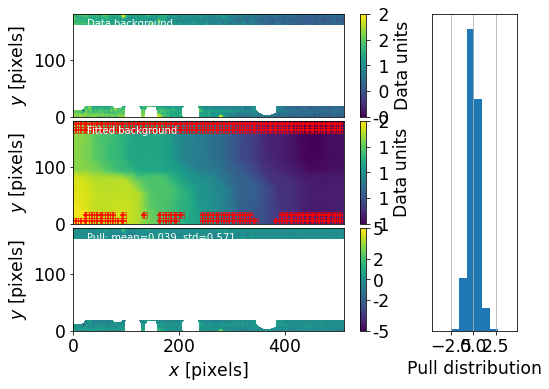

2021-11-03 22:32:59  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=1.120 ADU/s, RMS=0.233 ADU/s.
2021-11-03 22:32:59  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [1487:1999,1226:1407] (size (512, 181))
	New target position in spectrogram frame: [-425.0584459703757, 90.44053514825623]


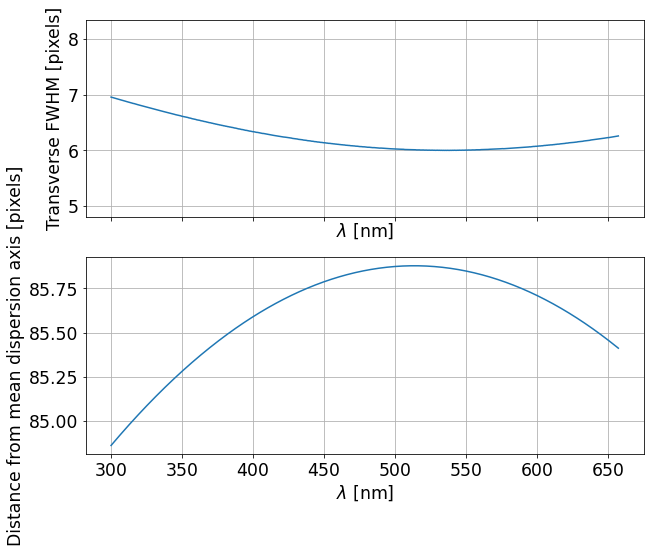

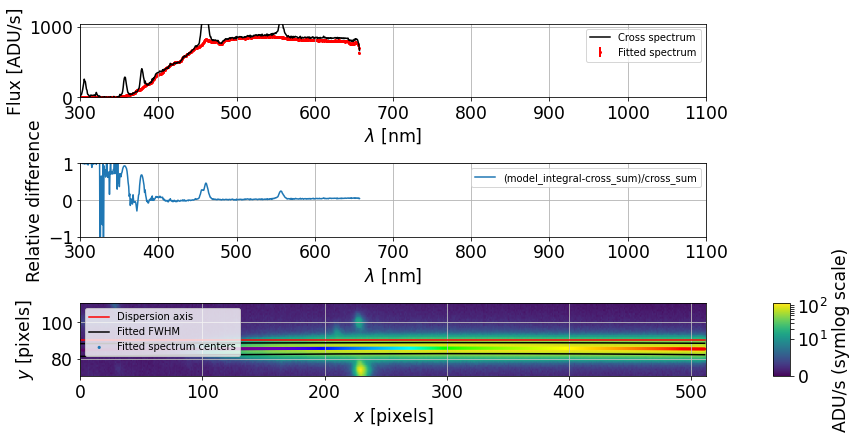

2021-11-03 22:33:01  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


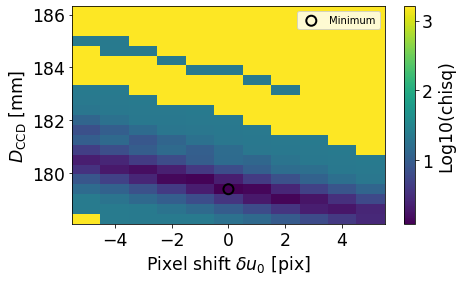

2021-11-03 22:33:06  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.030pix
	D = 179.458 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -3.4 sigma shift)
2021-11-03 22:33:06  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.
2021-11-03 22:33:10  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=4.0723e+06 initial chisq_red=227.25
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-2.98388765  0.01707229]
	New parameters: [-1.904       0.01707229]
	Final cost=2.8243e+06 final chisq_red=157.6 computed in 3.38s
2021-11-03 22:33:35  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=2.8243e+06 initial chisq_red=157.6
		 Line search: alpha_min=0 iter=53 funcalls=57
	Parameter shifts: [-0.  0.]
	New parameters: [-1.904       0.01707229]
	Final cost=2.8243e+06 final chisq_red=157.6 computed in 24.70s
2021-11-03 22:33:35  spectractor.fi

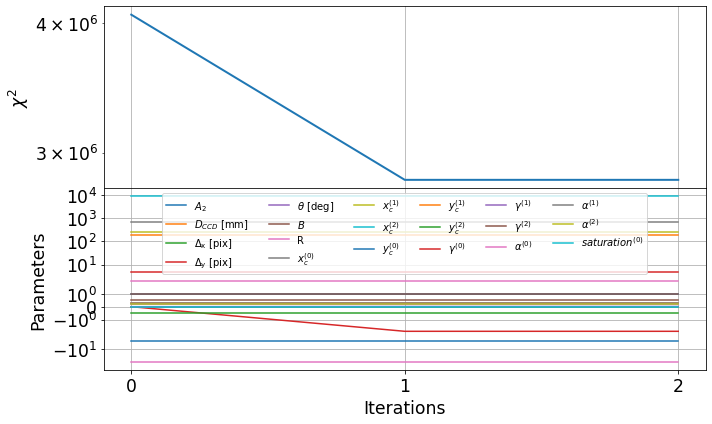

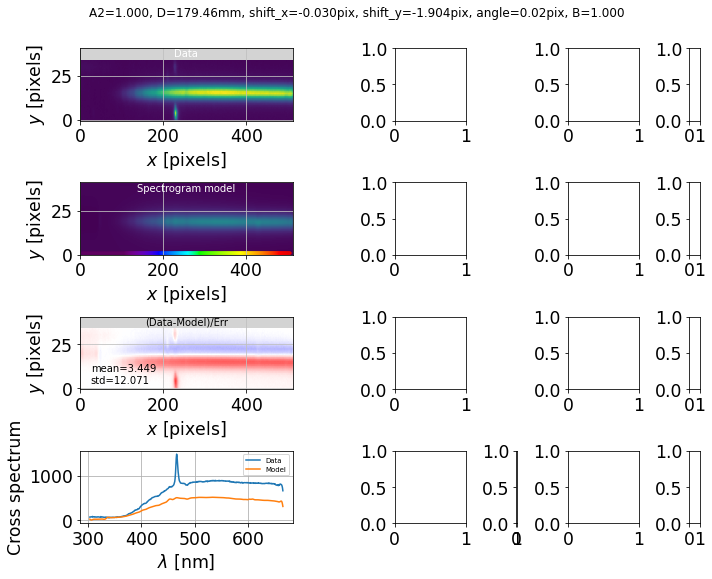

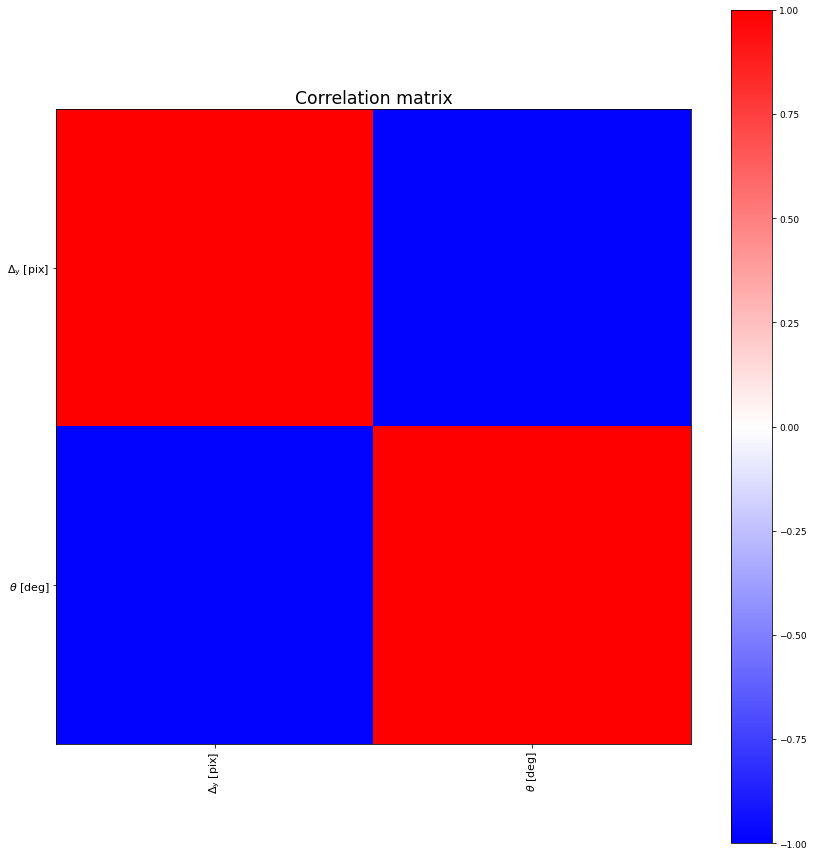

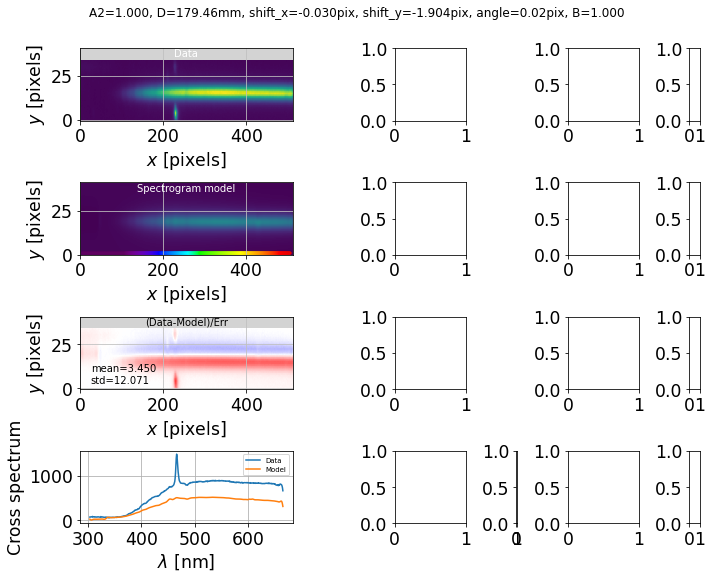

2021-11-03 22:33:41  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.79457958e+02 -2.98201825e-02 -1.90400000e+00
  1.70722903e-02  1.00000000e+00 -3.52048715e+01  6.82153920e+02
  2.55500000e+02 -1.07693041e-13 -4.82730913e+00  2.76256895e-01
 -4.78499692e-01  4.79902104e+00  1.70785567e-01  5.34623923e-01
  1.97216195e+00  3.11568470e-01  1.92420427e-01  8.49971989e+03]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'x_c_0', 'x_c_1', 'x_c_2', 'y_c_0', 'y_c_1', 'y_c_2', 'gamma_0', 'gamma_1', 'gamma_2', 'alpha_0', 'alpha_1', 'alpha_2', 'saturation_0']
2021-11-03 22:34:08  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=2.8243e+06 initial chisq_red=157.61
		 Line search: alpha_min=8.65e-11 iter=49 funcalls=53
	Parameter shifts: [-2.67662556e-10  1.58107120e-12  3.78235886e-10  4.09505366e-11
  1.97847925e-12  9.41788576e-11  3.75456972e-11  4.30755851e-13]
	New parameters

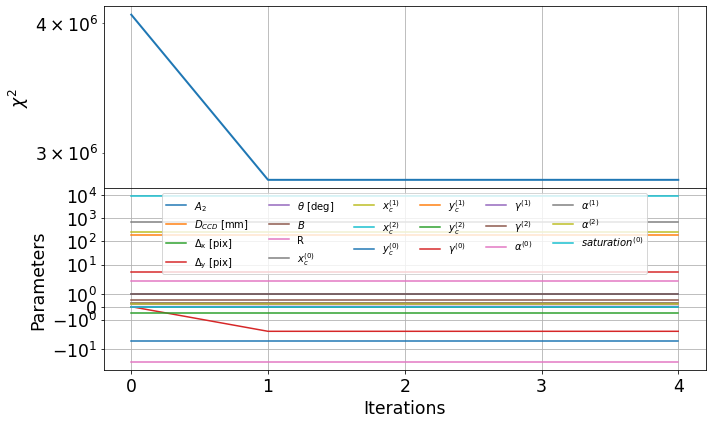

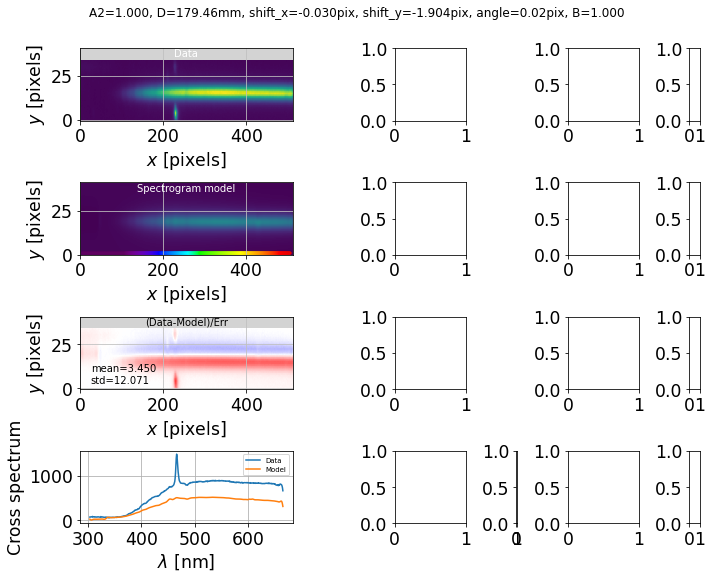

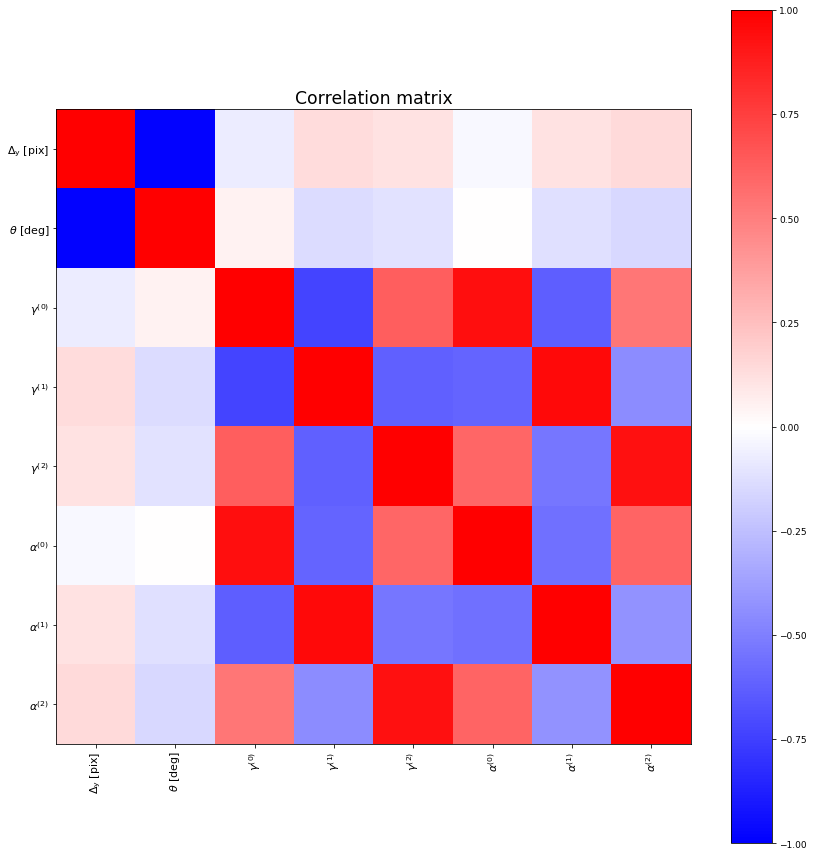

2021-11-03 22:34:12  spectractor.fit.fitter run_minimisation     DEBUG  
	Start guess: [0.]
2021-11-03 22:34:14  spectractor.fit.fitter run_minimisation     DEBUG  
	 final_simplex: (array([[4.70926996],
       [4.70926996]]), array([3.89499087e-05, 3.89499087e-05]))
           fun: 3.8949908691257184e-05
       message: 'Optimization terminated successfully.'
          nfev: 32
           nit: 16
        status: 0
       success: True
             x: array([4.70926996])
2021-11-03 22:34:14  spectractor.fit.fitter run_minimisation     DEBUG  
	Minimize: total computation time: 1.5386722087860107s


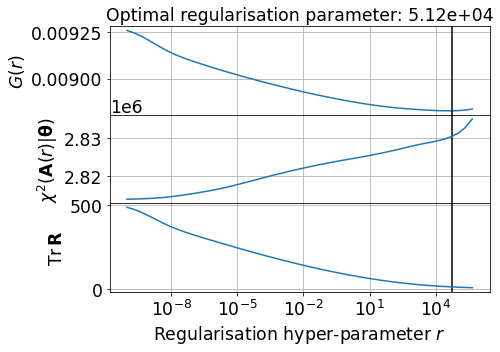

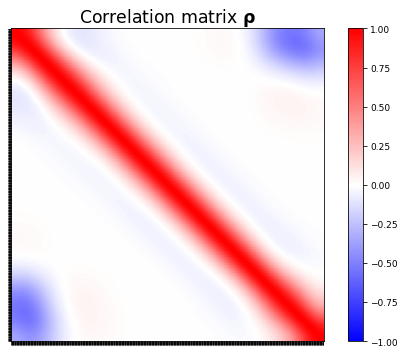

2021-11-03 22:34:22  RegFitWorkspace print_regularisation_summary INFO   
	Optimal regularisation parameter: 51200.000000000065
	Tr(R) = 12.517813391418816
	N_params = 512
	N_data = 17920 (without mask and outliers)
2021-11-03 22:34:22  FullForwardModelFitWorkspace run_ffm_minimisation WARNING 
	Trace of final covariance matrix (319.29871820275685) is below the trace of the prior covariance matrix (15712.888435472025). This is probably due to a very high regularisation parameter in case of a bad fit. Therefore the final covariance matrix is mulitiplied by the ratio of the traces and the amplitude parameters are very close the amplitude priors.
2021-11-03 22:34:48  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=2.8303e+06 initial chisq_red=157.94
		 Line search: alpha_min=2.91e-11 iter=50 funcalls=54
	Parameter shifts: [-9.31886294e-11  7.65478828e-13  1.28982436e-10  1.06499254e-11
  1.26147306e-12  3.15285345e-11  1.27046399e-11 -1.18829244e-12]
	New pa

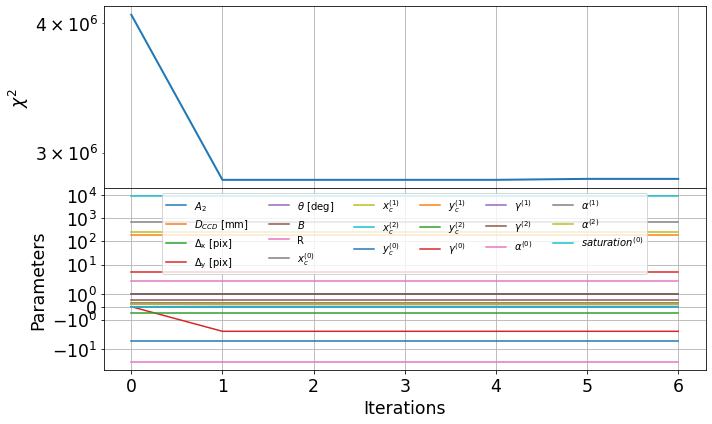

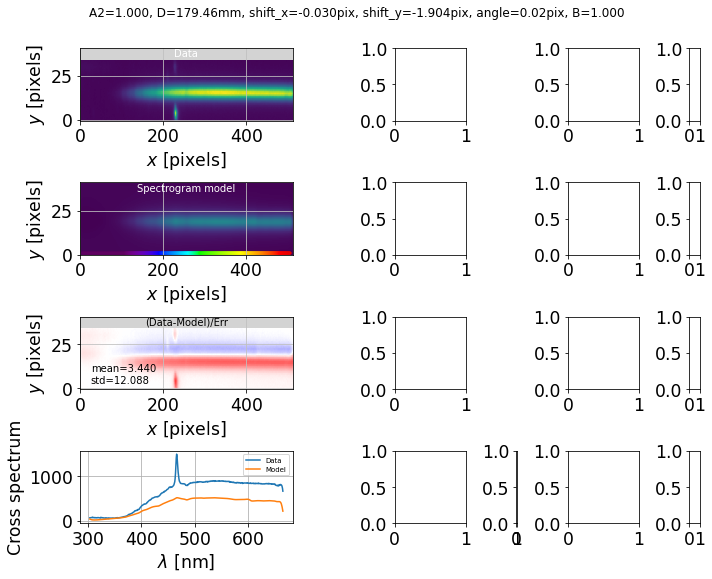

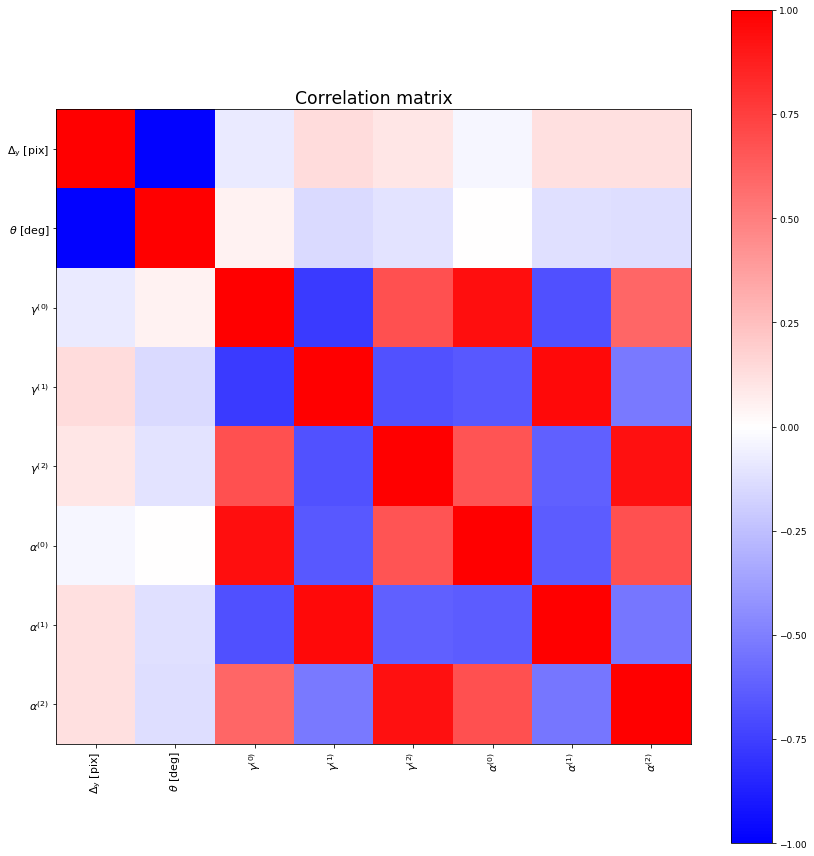

2021-11-03 22:34:52  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [228, 229, 230, 231, 232, 233, 739, 740, 741, 742, 743, 744, 745, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3811, 3812, 3813, 3814, 3815, 4323, 4324, 4325, 4326, 6058, 6069, 6071, 6080, 6090, 6092, 6096, 6097, 6098, 6099, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349, 6350, 6351, 6352, 6353, 6354, 6355, 6356, 6357, 6358, 6359, 6360, 6361, 6362, 6

2021-11-03 22:34:52  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 2212 / 20992 data points (10.54%) at more than 20-sigma from best-fit model.
2021-11-03 22:34:58  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=6.3681e+05 initial chisq_red=35.536
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-3.90629999 -0.03675971  1.85673646 -4.68519433  2.67474859  0.02307272
 -1.13836674  0.14260454]
	New parameters: [-1.904      -0.01968742  6.6557575  -4.51440876  3.20937252  1.99523467
 -0.82679827  0.33502496]
	Final cost=6.0942e+05 final chisq_red=34.008 computed in 6.00s
2021-11-03 22:35:24  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=6.0942e+05 initial chisq_red=34.008
		 Line search: alpha_min=7.33e-11 iter=49 funcalls=53
	Parameter shifts: [-4.30824611e-10  9.56094637e-12 -1.28832344e-10 -7.31243096e-11
 -1.10628760e-10 -8.70261385e-12  2.19013643e-11 -1.45606973e-11]
	New pa

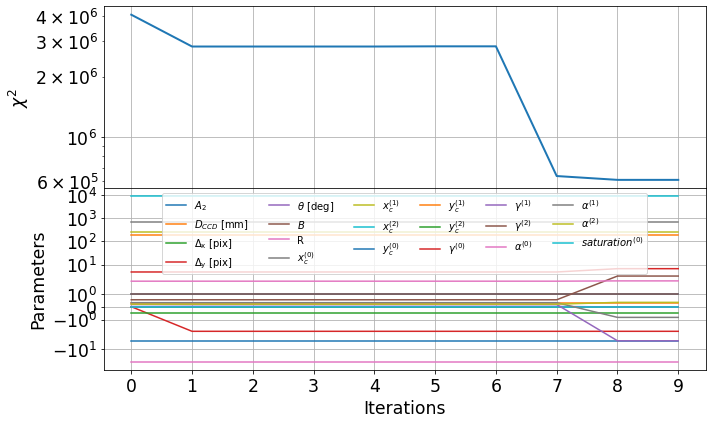

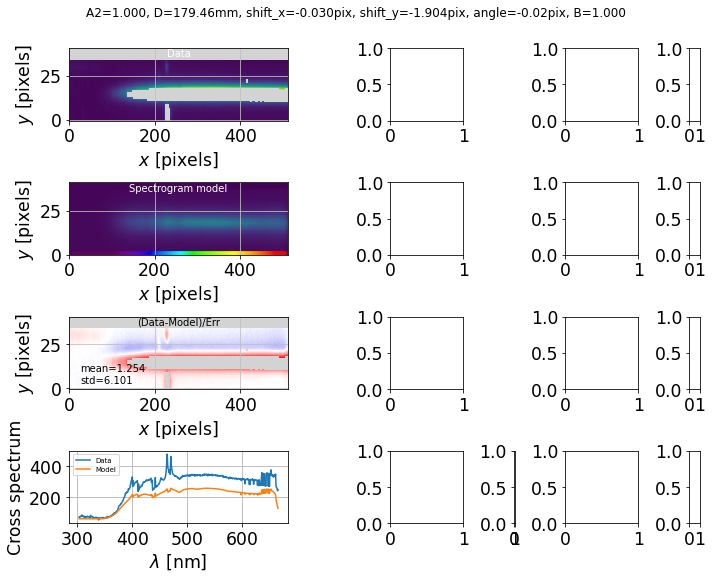

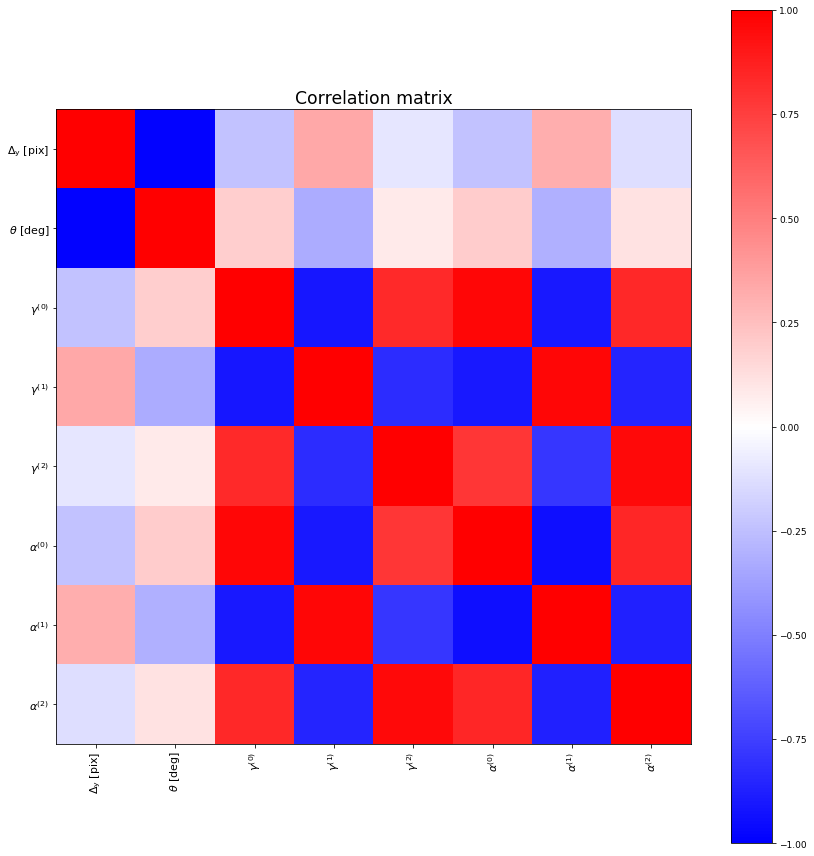

2021-11-03 22:35:28  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [228, 229, 230, 231, 232, 233, 739, 740, 741, 742, 743, 744, 745, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3811, 3812, 3813, 3814, 3815, 4323, 4324, 4325, 4326, 6107, 6133, 6134, 6136, 6137, 6138, 6139, 6140, 6141, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349, 6350, 6351, 6352, 6353, 6354, 6355, 6356, 6357, 6358, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 6366, 6367, 6368, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6377, 6378, 6379, 6380, 6381, 6382, 6383, 6384, 6385, 6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6398, 6399, 6400, 6401, 6402, 6403, 6404, 6

2021-11-03 22:35:28  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 2499 / 20992 data points (11.90%) at more than 20-sigma from best-fit model.
2021-11-03 22:35:47  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=4.759e+05 initial chisq_red=26.557
		 Line search: alpha_min=0 iter=33 funcalls=37
	Parameter shifts: [-0.  0. -0. -0. -0. -0.  0. -0.]
	New parameters: [-1.904      -0.01968742  6.6557575  -4.51440876  3.20937252  1.99523467
 -0.82679827  0.33502496]
	Final cost=4.759e+05 final chisq_red=26.557 computed in 18.42s
2021-11-03 22:35:47  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 0 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-05.
2021-11-03 22:35:47  spectractor.fit.fitter print_parameter_summary INFO   
	shift_y [pix]: -1.90 +0.06 -0.06
	angle [deg]: -0.020 +0.005 -0.005
	gamma_0: 6.66 +0.08 -0.08
	gamma_1: -4.5 +0.2 -0.2
	ga

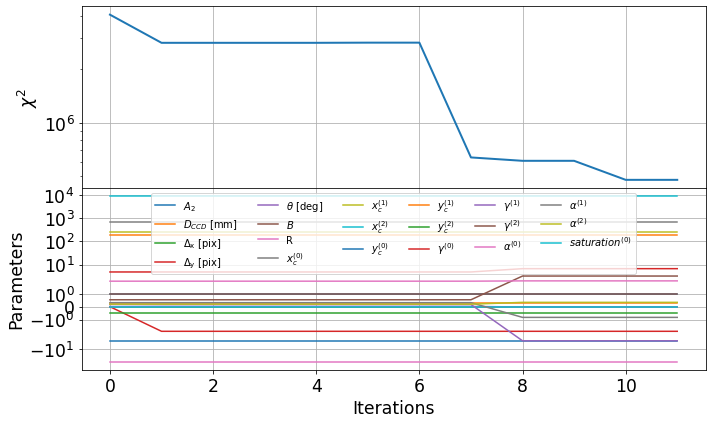

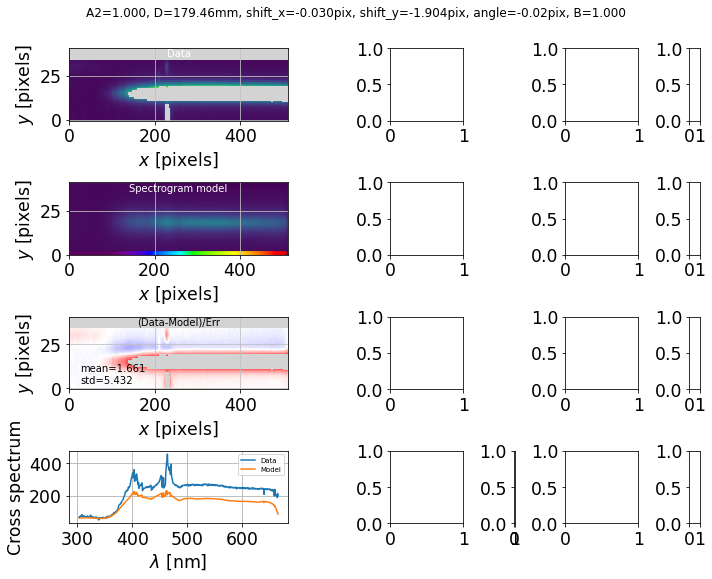

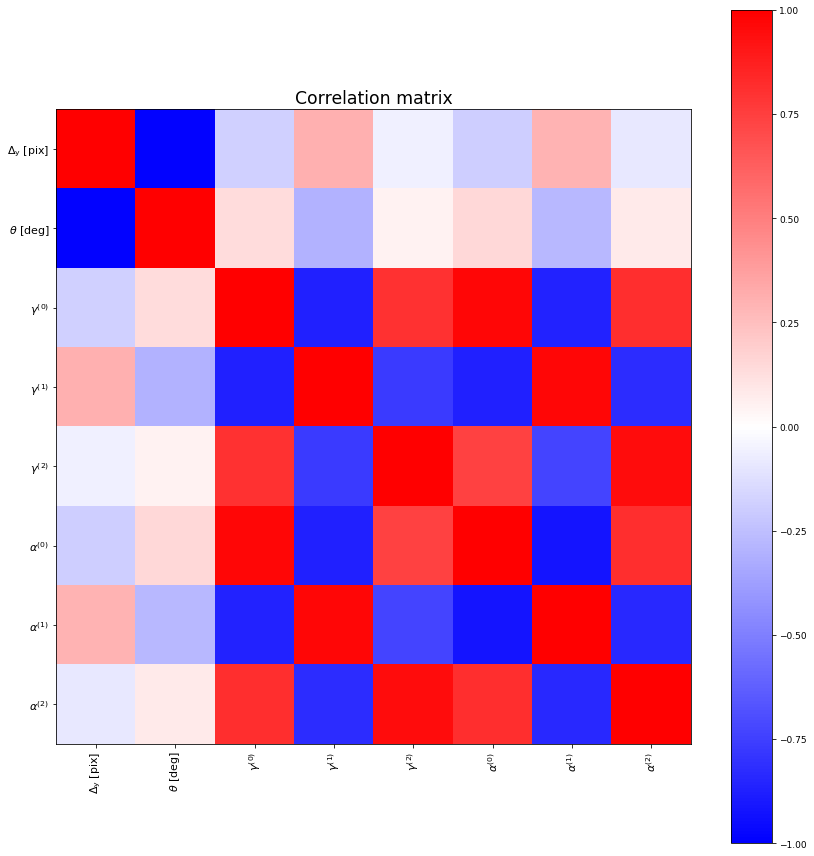

2021-11-03 22:35:51  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [228, 229, 230, 231, 232, 233, 739, 740, 741, 742, 743, 744, 745, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3811, 3812, 3813, 3814, 3815, 4323, 4324, 4325, 4326, 5973, 5987, 5997, 6026, 6031, 6034, 6038, 6040, 6043, 6048, 6049, 6051, 6055, 6056, 6058, 6061, 6064, 6066, 6067, 6069, 6071, 6072, 6073, 6075, 6076, 6077, 6079, 6080, 6081, 6082, 6084, 6086, 6087, 6088, 6089, 6090, 6092, 6093, 6095, 6096, 6097, 6098, 6099, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6

2021-11-03 22:35:51  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 2603 / 20992 data points (12.40%) at more than 20-sigma from best-fit model.
2021-11-03 22:35:51  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 130.25711297988892s


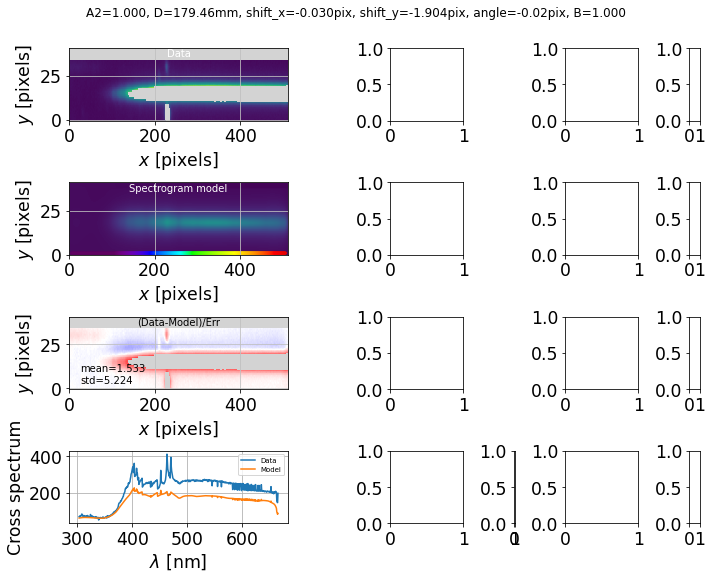

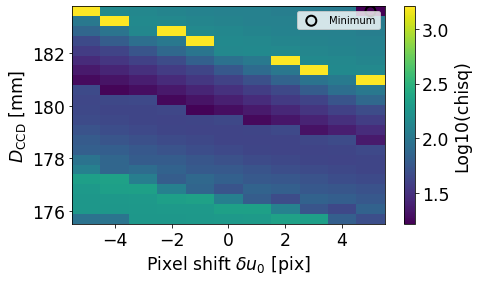

2021-11-03 22:35:59  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: 2.000pix
	D = 184.229 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, 3.0 sigma shift)
2021-11-03 22:36:33  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=4.1857e+05 initial chisq_red=22.268
		 Line search: alpha_min=2.72e-09 iter=43 funcalls=47
	Parameter shifts: [-1.22104859e-08  5.83549568e-11  6.95070864e-09 -5.04883135e-09
 -2.29390446e-09  2.35535253e-09 -6.38910496e-10 -3.12057352e-10]
	New parameters: [-1.904      -0.01968742  6.6557575  -4.51440876  3.20937251  1.99523467
 -0.82679827  0.33502496]
	Final cost=4.178e+05 final chisq_red=22.227 computed in 33.16s
2021-11-03 22:36:33  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 0 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-05.
2021-11-03 22:36:33  spectractor.fit.fitter print_parameter_summary INFO   
	shift_y [pix]: -1.90 

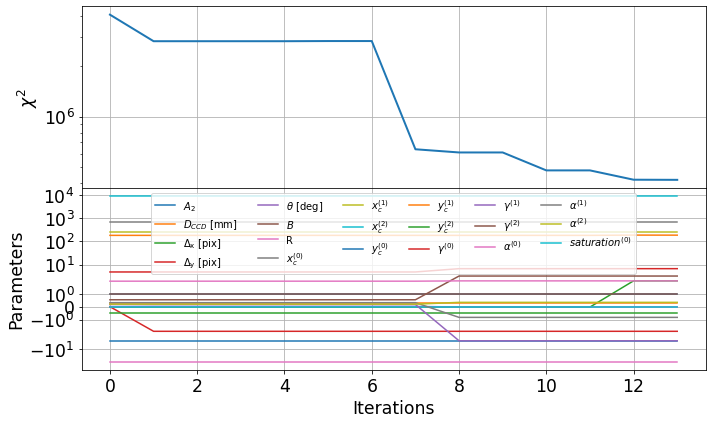

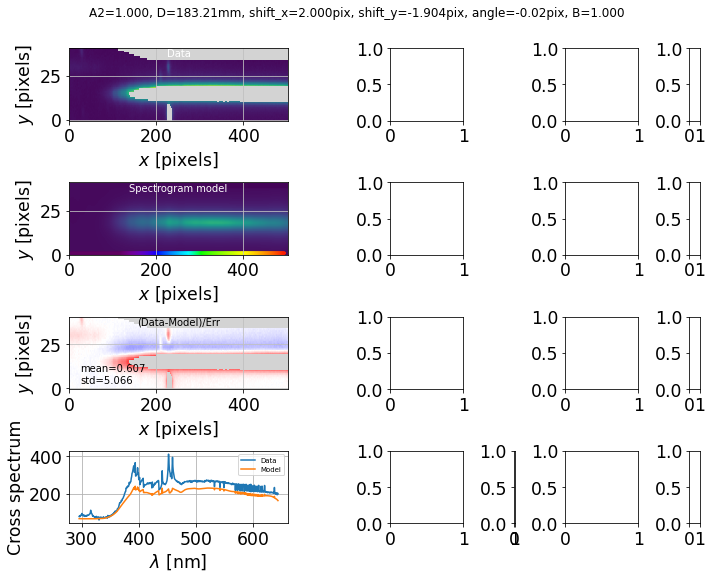

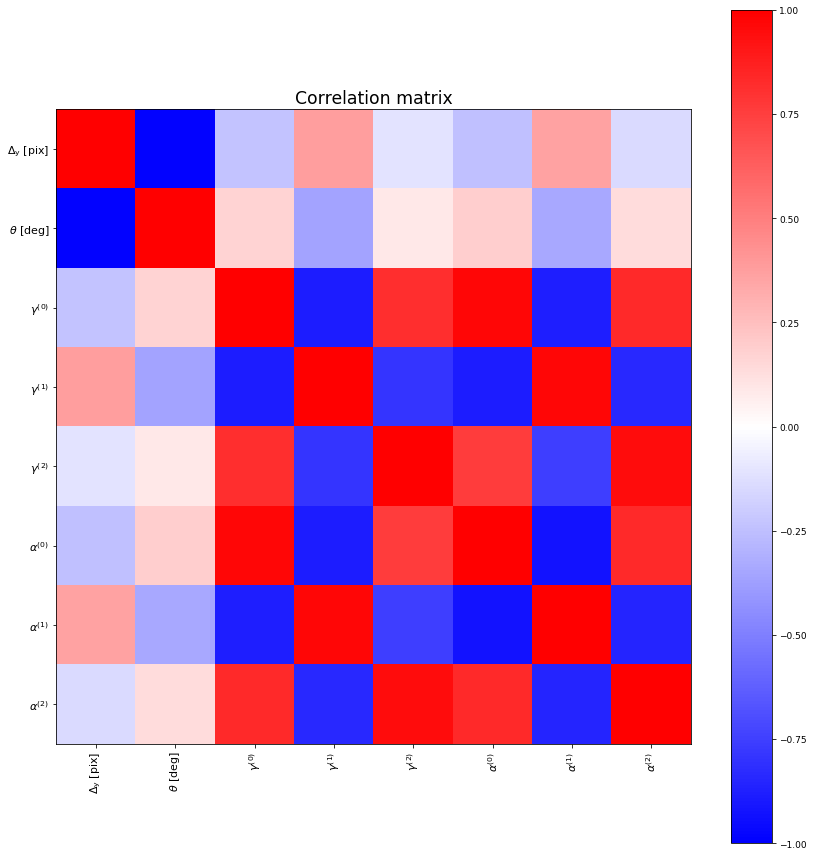

2021-11-03 22:36:37  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [228, 229, 230, 231, 232, 233, 739, 740, 741, 742, 743, 744, 745, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3811, 3812, 3813, 3814, 3815, 4323, 4324, 4325, 4326, 6107, 6129, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349, 6350, 6351, 6352, 6353, 6354, 6355, 6356, 6357, 6358, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 6366, 6367, 6368, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6377, 6378, 6379, 6380, 6381, 6382, 6383, 6384, 6385, 6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6398, 6399, 6400, 6401, 6

2021-11-03 22:36:37  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 2490 / 20992 data points (11.86%) at more than 20-sigma from best-fit model.
2021-11-03 22:37:18  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=4.178e+05 initial chisq_red=22.227
		 Line search: alpha_min=1.46e-11 iter=54 funcalls=58
	Parameter shifts: [-6.54781052e-11  3.29180278e-13  3.69226452e-11 -2.68933966e-11
 -1.20459922e-11  1.25768422e-11 -3.42205468e-12 -1.60102983e-12]
	New parameters: [-1.904      -0.01968742  6.6557575  -4.51440876  3.20937251  1.99523467
 -0.82679827  0.33502496]
	Final cost=4.178e+05 final chisq_red=22.227 computed in 40.18s
2021-11-03 22:37:18  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 0 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-05.
2021-11-03 22:37:18  spectractor.fit.fitter print_parameter_summary INFO   
	shift_y [pix]: -1.9

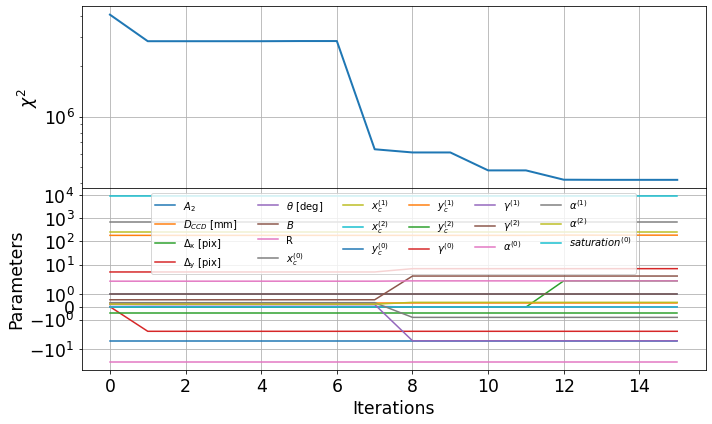

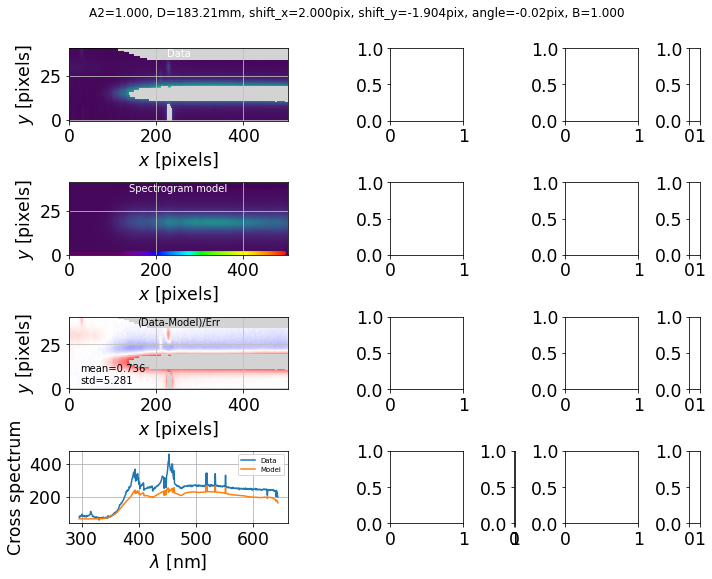

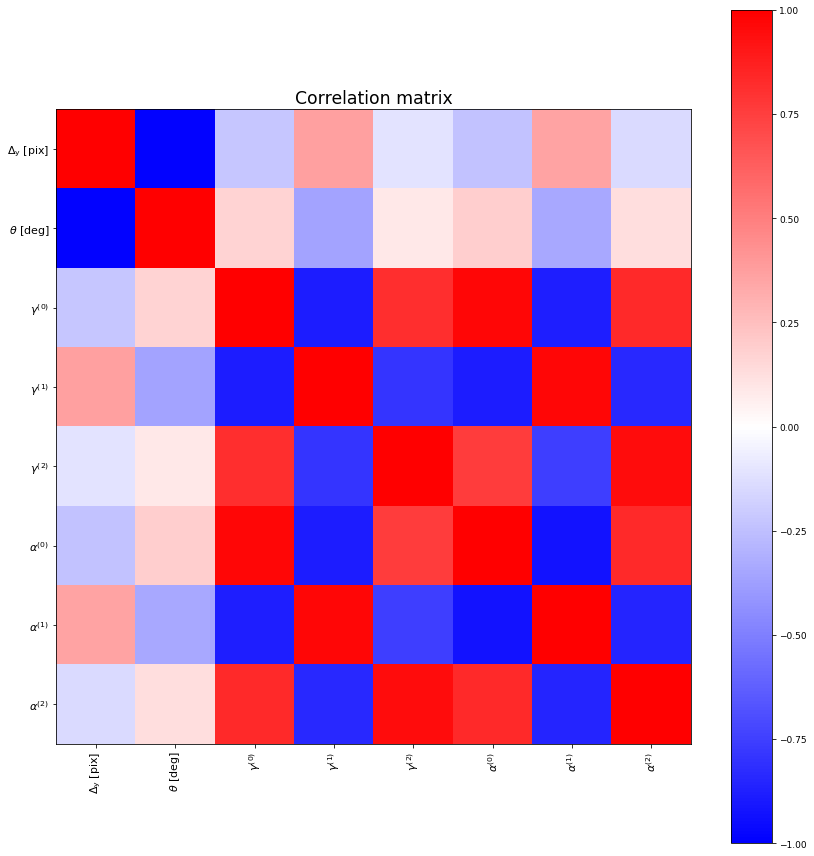

2021-11-03 22:37:21  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [228, 229, 230, 231, 232, 233, 739, 740, 741, 742, 743, 744, 745, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3811, 3812, 3813, 3814, 3815, 4323, 4324, 4325, 4326, 6107, 6129, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349, 6350, 6351, 6352, 6353, 6354, 6355, 6356, 6357, 6358, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 6366, 6367, 6368, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6377, 6378, 6379, 6380, 6381, 6382, 6383, 6384, 6385, 6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6398, 6399, 6400, 6401, 6

2021-11-03 22:37:21  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 2490 / 20992 data points (11.86%) at more than 20-sigma from best-fit model.
2021-11-03 22:37:21  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-11-03 22:37:21  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 220.50545001029968s


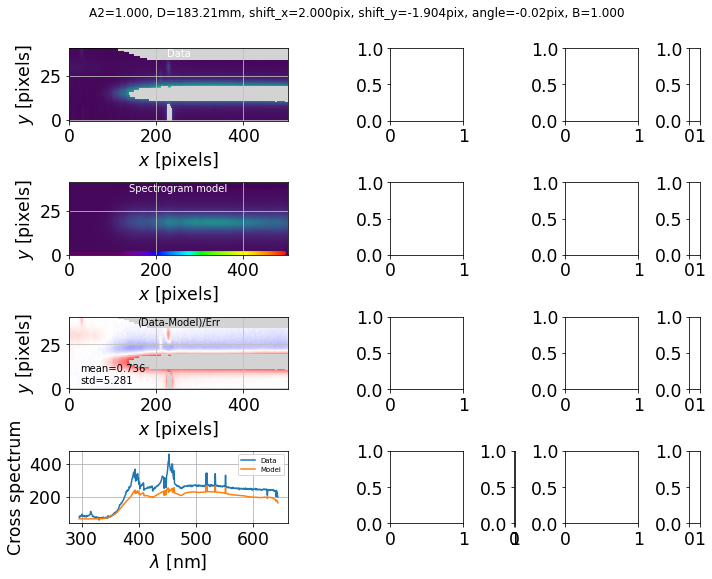

2021-11-03 22:37:27  Spectrum   calibrate_spectrum   WARNING 
	Minimum chisq is on the edge of the exploration grid.


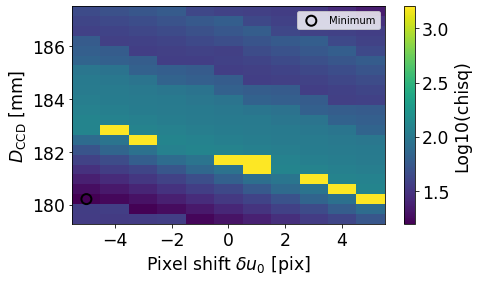

2021-11-03 22:37:30  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -2.000pix
	D = 179.623 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -3.2 sigma shift)
2021-11-03 22:37:31  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2021-11-03 22:37:31  astroquery _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-11-03 22:37:31  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000269_quickLookExp_spectrum.fits
2021-11-03 22:37:31  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000269_quickLookExp_spectrogram.fits


    Line    Tabulated  Detected ...   Chisq   Eqwidth_mod Eqwidth_data
                nm        nm    ...  reduced       nm          nm     
----------- --------- --------- ... --------- ----------- ------------
   $Fe_{I}$   382.172 381.70837 ...  35.83665  0.24849279 -0.043707147
  $Ca_{II}$ 393.49777  391.7363 ...  35.83665   0.3791788    1.0482476
  $Ca_{II}$ 396.97995 395.23886 ...  35.83665   0.6040726    1.0944725
$H\epsilon$   397.133 398.46674 ...  35.83665  0.04057073   0.25691697
  $H\delta$  410.3374 410.37186 ...  35.83665   2.0299766    7.8664675
   $Fe_{I}$ 430.93433  424.7028 ...  35.83665   3.6114407    11.746687
  $H\gamma$  434.1454 432.53986 ...  35.83665   2.0452428     8.949522
   $Fe_{I}$ 438.50186 440.29483 ...  35.83665   1.6179872     8.586739
   $He_{I}$  447.2498 446.54596 ...  35.83665   2.2727506   -1.8529403
   $H\beta$ 486.46292 484.63345 ... 20.508827    0.689881    0.6746902
   $Mg_{I}$  517.4433  515.0305 ... 20.508827  0.83461255     2.076601
   $Mg

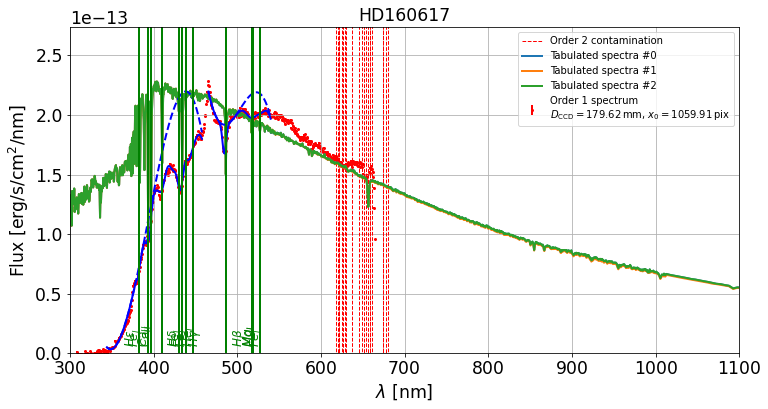

In [71]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

# Backup output

In [72]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000269_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000269_quickLookExp_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000269_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000269_quickLookExp_spectrogram.fits']

In [73]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/plots/fit_chromatic_psf_best_fit_noprior.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/plots/rotated_image.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/plots/fwhm.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/plots/order0_centroid_fit.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/plots/HD160617_spectrum.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/plots/regularisation.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/